In [1]:
! python -m spacy download en_core_web_sm
! pip install sentence-transformers umap-learn bertopic
! pip install spacy
! pip install openpyxl
! pip install hdbscan
! pip install datasets
! pip install transformers torch
! pip install --upgrade sentence_transformers umap-learn hdbscan bertopic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import os
import pandas as pd
import openpyxl
from datetime import datetime
import matplotlib.pyplot as plt
from textblob import TextBlob
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from bertopic import BERTopic
import random
import numpy as np
import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.cm as cm
from collections import Counter
from umap import UMAP
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from gensim import corpora, models
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, fcluster

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizer model
nltk.download('stopwords')  # Stopwords list
nltk.download('wordnet')  # Lexical database for lemmatization
nltk.download('omw-1.4')  # Open Multilingual Wordnet, needed for lemmatization in multiple languages

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/helgegeurtjacobusmoes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/helgegeurtjacobusmoes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/helgegeurtjacobusmoes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/helgegeurtjacobusmoes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Load the Excel file into a DataFrame
excel_path = '/Users/helgegeurtjacobusmoes/Desktop/thesis data/Updated_Merged_Data.xlsx'

# Load the Excel file into a DataFrame
updated_merged_data = pd.read_excel(excel_path)

updated_merged_data

Headline   
0     Nee, kunstmatige intelligentie gaat ons niet u...  \
1     Wereldleiders zoeken grip op kunstmatige intel...   
2          Kunstmatige intelligentie is best bedreigend   
3     Mensen zijn een stuk efficiënter dan kunstmati...   
4     Bedreigt kunstmatige intelligentie ons godsbeeld?   
...                                                 ...   
6441                                 De rauwe realiteit   
6442                            No Headline In Original   
6443               Groeten uit het hart van de hightech   
6444              De complete lijst Jonge Talenten 2019   
6445                            No Headline In Original   

                                            Publication   
0              Trouw, Verdieping; Blz. 4, 5, 2044 words  \
1                     Trouw, Vandaag; Blz. 6, 528 words   
2                   Trouw, Tijdgeest; Blz. 8, 576 words   
3                     Trouw, Vandaag; Blz. 3, 741 words   
4     Trouw, Religie en Filosofie; Blz. 8, 9, 1367 w...   
...                                                 ...   
6441  Het Financieele Dagblad, MORGEN; Blz. 4, 2920 ...   
6442  Het Financieele Dagblad, PAGINA 13; Blz. 13, 1...   
6443  Het Financieele Dagblad, WEEKEND; Blz. 6, 2799...   
6444  Het Financieele Dagblad, FD PERSOONLIJK; Arbei...   
6445  Het Financieele Dagblad, DE WERELD; Blz. 30, 9...   

                                                    URL   
0     https://advance.lexis.com/api/document?collect...  \
1     https://advance.lexis.com/api/document?collect...   
2     https://advance.lexis.com/api/document?collect...   
3     https://advance.lexis.com/api/document?collect...   
4     https://advance.lexis.com/api/document?collect...   
...                                                 ...   
6441  https://advance.lexis.com/api/document?collect...   
6442  https://advance.lexis.com/api/document?collect...   
6443  https://advance.lexis.com/api/document?collect...   
6444  https://advance.lexis.com/api/document?collect...   
6445  https://advance.lexis.com/api/document?collect...   

                  News Outlet                  Type of News  Word Count   
0                       Trouw                    Verdieping        2044  \
1                       Trouw                       Vandaag         528   
2                       Trouw                     Tijdgeest         576   
3                       Trouw                       Vandaag         741   
4                       Trouw          Religie en Filosofie        1367   
...                       ...                           ...         ...   
6441  Het Financieele Dagblad                        MORGEN        2920   
6442  Het Financieele Dagblad                        PAGINA         114   
6443  Het Financieele Dagblad                       WEEKEND        2799   
6444  Het Financieele Dagblad  FD PERSOONLIJK; Arbeidsmarkt        8007   
6445  Het Financieele Dagblad                     DE WERELD         969   

                                                   Body   
0     Welkom in de AI-fabriek serie\nDat kunstmatige...  \
1     Op het Britse landgoed Bletchley Park werden t...   
2     Of kunstmatige intelligentie nuttig is (Tijdge...   
3     De wereld raakte het afgelopen jaar in de ban ...   
4     Theologisch elftal\n'In het begin was het Woor...   
...                                                 ...   
6441  Grootse oplossingen\nDrie stedelijke 'ontwrich...   
6442  klinkt als muziek\nDe Walkman, van Sony, is vo...   
6443  Het is zover voor 'onze man in San Francisco'....   
6444  Rebel werkte zes jaar bij zakenbank Morgan Sta...   
6445  The Conversation (Londen)Gates Notes (VS)The E...   

                            Publication Date  
0                  7 december 2023 donderdag  
1                    3 november 2023 vrijdag  
2                       13 mei 2023 zaterdag  
3                   21 oktober 2023 zaterdag  
4                   16 december 2022 vrijdag  
...                         

In [5]:
# Load Dutch stopwords
stop_words_nl = set(stopwords.words('dutch'))

# Define a preprocess_text function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)
    # Remove numbers
    words = [re.sub(r'\d+', '', word) for word in words]
    # Remove punctuation and special characters
    words = [word for word in words if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('Dutch'))
    stop_words.update(['No Headline In Original', 'trouw', 'volkskrant', 'financieele', 'algemeen', 'dagblad', 'nrc', 'telegraaf'])
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back to text
    text = ' '.join(words)
    return text

# Create the Combined column and preprocess it
updated_merged_data["Combined"] = updated_merged_data["Headline"].fillna("") + " " + updated_merged_data["Body"].fillna("")
updated_merged_data["Combined"] = updated_merged_data["Combined"].apply(preprocess_text)

# Ensure there are no NaN values in the Combined column
updated_merged_data.dropna(subset=["Combined"], inplace=True)
updated_merged_data.reset_index(drop=True, inplace=True)

updated_merged_data  

Headline   
0     Nee, kunstmatige intelligentie gaat ons niet u...  \
1     Wereldleiders zoeken grip op kunstmatige intel...   
2          Kunstmatige intelligentie is best bedreigend   
3     Mensen zijn een stuk efficiënter dan kunstmati...   
4     Bedreigt kunstmatige intelligentie ons godsbeeld?   
...                                                 ...   
6441                                 De rauwe realiteit   
6442                            No Headline In Original   
6443               Groeten uit het hart van de hightech   
6444              De complete lijst Jonge Talenten 2019   
6445                            No Headline In Original   

                                            Publication   
0              Trouw, Verdieping; Blz. 4, 5, 2044 words  \
1                     Trouw, Vandaag; Blz. 6, 528 words   
2                   Trouw, Tijdgeest; Blz. 8, 576 words   
3                     Trouw, Vandaag; Blz. 3, 741 words   
4     Trouw, Religie en Filosofie; Blz. 8, 9, 1367 w...   
...                                                 ...   
6441  Het Financieele Dagblad, MORGEN; Blz. 4, 2920 ...   
6442  Het Financieele Dagblad, PAGINA 13; Blz. 13, 1...   
6443  Het Financieele Dagblad, WEEKEND; Blz. 6, 2799...   
6444  Het Financieele Dagblad, FD PERSOONLIJK; Arbei...   
6445  Het Financieele Dagblad, DE WERELD; Blz. 30, 9...   

                                                    URL   
0     https://advance.lexis.com/api/document?collect...  \
1     https://advance.lexis.com/api/document?collect...   
2     https://advance.lexis.com/api/document?collect...   
3     https://advance.lexis.com/api/document?collect...   
4     https://advance.lexis.com/api/document?collect...   
...                                                 ...   
6441  https://advance.lexis.com/api/document?collect...   
6442  https://advance.lexis.com/api/document?collect...   
6443  https://advance.lexis.com/api/document?collect...   
6444  https://advance.lexis.com/api/document?collect...   
6445  https://advance.lexis.com/api/document?collect...   

                  News Outlet                  Type of News  Word Count   
0                       Trouw                    Verdieping        2044  \
1                       Trouw                       Vandaag         528   
2                       Trouw                     Tijdgeest         576   
3                       Trouw                       Vandaag         741   
4                       Trouw          Religie en Filosofie        1367   
...                       ...                           ...         ...   
6441  Het Financieele Dagblad                        MORGEN        2920   
6442  Het Financieele Dagblad                        PAGINA         114   
6443  Het Financieele Dagblad                       WEEKEND        2799   
6444  Het Financieele Dagblad  FD PERSOONLIJK; Arbeidsmarkt        8007   
6445  Het Financieele Dagblad                     DE WERELD         969   

                                                   Body   
0     Welkom in de AI-fabriek serie\nDat kunstmatige...  \
1     Op het Britse landgoed Bletchley Park werden t...   
2     Of kunstmatige intelligentie nuttig is (Tijdge...   
3     De wereld raakte het afgelopen jaar in de ban ...   
4     Theologisch elftal\n'In het begin was het Woor...   
...                                                 ...   
6441  Grootse oplossingen\nDrie stedelijke 'ontwrich...   
6442  klinkt als muziek\nDe Walkman, van Sony, is vo...   
6443  Het is zover voor 'onze man in San Francisco'....   
6444  Rebel werkte zes jaar bij zakenbank Morgan Sta...   
6445  The Conversation (Londen)Gates Notes (VS)The E...   

                            Publication Date   
0                  7 december 2023 donderdag  \
1                    3 november 2023 vrijdag   
2                       13 mei 2023 zaterdag   
3                   21 oktober 2023 zaterdag   
4                   16 december 2022 vrijdag   
...                   

In [6]:
# Dictionary for Dutch to English month translation
dutch_months = {
    "januari": "January", "februari": "February", "maart": "March",
    "april": "April", "mei": "May", "juni": "June",
    "juli": "July", "augustus": "August", "september": "September",
    "oktober": "October", "november": "November", "december": "December"
}

# Function to translate Dutch month names to English and format the date
def translate_date(date_str):
    if pd.isna(date_str):
        return None  # Return None if the date is NaN
    try:
        parts = date_str.split()
        if len(parts) >= 3:
            day = parts[0].zfill(2)  # Ensure day is two digits
            month_dutch = parts[1].lower()
            year = parts[2]
            month_english = dutch_months.get(month_dutch, None)
            if not month_english:
                return None  # Return None if the month is not found
            date_str_english = f"{day}-{month_english}-{year}"
            date_obj = datetime.strptime(date_str_english, "%d-%B-%Y")
            return date_obj.strftime("%d-%m-%Y")
    except Exception as e:
        print(f"Error parsing date '{date_str}': {e}")
        return None

# Apply the translation and conversion function to the 'Publication Date' column
updated_merged_data['Publication Date'] = updated_merged_data['Publication Date'].apply(translate_date)

# Print out some of the cleaned data to verify
updated_merged_data

Headline   
0     Nee, kunstmatige intelligentie gaat ons niet u...  \
1     Wereldleiders zoeken grip op kunstmatige intel...   
2          Kunstmatige intelligentie is best bedreigend   
3     Mensen zijn een stuk efficiënter dan kunstmati...   
4     Bedreigt kunstmatige intelligentie ons godsbeeld?   
...                                                 ...   
6441                                 De rauwe realiteit   
6442                            No Headline In Original   
6443               Groeten uit het hart van de hightech   
6444              De complete lijst Jonge Talenten 2019   
6445                            No Headline In Original   

                                            Publication   
0              Trouw, Verdieping; Blz. 4, 5, 2044 words  \
1                     Trouw, Vandaag; Blz. 6, 528 words   
2                   Trouw, Tijdgeest; Blz. 8, 576 words   
3                     Trouw, Vandaag; Blz. 3, 741 words   
4     Trouw, Religie en Filosofie; Blz. 8, 9, 1367 w...   
...                                                 ...   
6441  Het Financieele Dagblad, MORGEN; Blz. 4, 2920 ...   
6442  Het Financieele Dagblad, PAGINA 13; Blz. 13, 1...   
6443  Het Financieele Dagblad, WEEKEND; Blz. 6, 2799...   
6444  Het Financieele Dagblad, FD PERSOONLIJK; Arbei...   
6445  Het Financieele Dagblad, DE WERELD; Blz. 30, 9...   

                                                    URL   
0     https://advance.lexis.com/api/document?collect...  \
1     https://advance.lexis.com/api/document?collect...   
2     https://advance.lexis.com/api/document?collect...   
3     https://advance.lexis.com/api/document?collect...   
4     https://advance.lexis.com/api/document?collect...   
...                                                 ...   
6441  https://advance.lexis.com/api/document?collect...   
6442  https://advance.lexis.com/api/document?collect...   
6443  https://advance.lexis.com/api/document?collect...   
6444  https://advance.lexis.com/api/document?collect...   
6445  https://advance.lexis.com/api/document?collect...   

                  News Outlet                  Type of News  Word Count   
0                       Trouw                    Verdieping        2044  \
1                       Trouw                       Vandaag         528   
2                       Trouw                     Tijdgeest         576   
3                       Trouw                       Vandaag         741   
4                       Trouw          Religie en Filosofie        1367   
...                       ...                           ...         ...   
6441  Het Financieele Dagblad                        MORGEN        2920   
6442  Het Financieele Dagblad                        PAGINA         114   
6443  Het Financieele Dagblad                       WEEKEND        2799   
6444  Het Financieele Dagblad  FD PERSOONLIJK; Arbeidsmarkt        8007   
6445  Het Financieele Dagblad                     DE WERELD         969   

                                                   Body Publication Date   
0     Welkom in de AI-fabriek serie\nDat kunstmatige...       07-12-2023  \
1     Op het Britse landgoed Bletchley Park werden t...       03-11-2023   
2     Of kunstmatige intelligentie nuttig is (Tijdge...       13-05-2023   
3     De wereld raakte het afgelopen jaar in de ban ...       21-10-2023   
4     Theologisch elftal\n'In het begin was het Woor...       16-12-2022   
...                                                 ...              ...   
6441  Grootse oplossingen\nDrie stedelijke 'ontwrich...       14-10-2017   
6442  klinkt als muziek\nDe Walkman, van Sony, is vo...       29-04-2023   
6443  Het is zover voor 'onze man in San Francisco'....       20-08-2016   
6444  Rebel werkte zes jaar bij zakenbank Morgan Sta...       17-01-2019   
6445  The Conversation (Londen)Gates Notes (VS)The E...       08-12-2018   

                                               Combined  
0     nee kunstmatige intelligentie gaat uitroei

In [7]:
# Save the cleaned DataFrame to a new Excel file
updated_merged_data.to_excel("/Users/helgegeurtjacobusmoes/Desktop/thesis data/Cleaned_Updated_Merged_Data.xlsx", index=False)

# Save the cleaned DataFrame to a new CSV file
updated_merged_data.to_csv("/Users/helgegeurtjacobusmoes/Desktop/thesis data/Cleaned_Updated_Merged_Data.csv", index=False)

In [9]:
import pandas as pd
import re

# Load the data from the Excel file
file_path = "/Users/helgegeurtjacobusmoes/Desktop/thesis data/Cleaned_Updated_Merged_Data.xlsx"
data = pd.read_excel(file_path)

# Ensure all entries in the 'Combined' column are treated as strings
data['Combined'] = data['Combined'].astype(str)

# Count the occurrences of each word in the 'Combined' column
data['AI Count'] = data['Combined'].str.count(r'\bAI\b', flags=re.IGNORECASE)
data['Kunstmatige Intelligentie Count'] = data['Combined'].str.count(r'\bKunstmatige Intelligentie\b', flags=re.IGNORECASE)
data['Artificial Intelligence Count'] = data['Combined'].str.count(r'\bArtificial Intelligence\b', flags=re.IGNORECASE)

# Sum the counts for each word across all rows
total_ai_count = data['AI Count'].sum()
total_ki_count = data['Kunstmatige Intelligentie Count'].sum()
total_ai_full_count = data['Artificial Intelligence Count'].sum()

print(f"Total 'AI' count: {total_ai_count}")
print(f"Total 'Kunstmatige Intelligentie' count: {total_ki_count}")
print(f"Total 'Artificial Intelligence' count: {total_ai_full_count}")


Total 'AI' count: 7889
Total 'Kunstmatige Intelligentie' count: 10442
Total 'Artificial Intelligence' count: 276


## LDA Topic Modelling

This code outlines the procedure for topic modeling using advanced natural language processing (NLP) techniques, specifically utilizing the BERTopic model which incorporates embeddings, dimensionality reduction (UMAP), and clustering (HDBSCAN) to automatically categorize Dutch text data into topics:

1. **Setting Environment Variable**:
   - `os.environ["OMP_MAX_ACTIVE_LEVELS"] = "2"`
   - This line sets the maximum number of nested active parallel regions for the OpenMP environment to '2'. This could be intended to optimize the performance or parallelism of the subsequent computational processes, particularly when using libraries that employ multi-threading.

2. **Loading a Pre-trained Embedding Model**:
   - `embedding_model = SentenceTransformer('all-MiniLM-L6-v2', language="Dutch")`
   - This line initializes a multi-language embedding model, capable of converting sentences into numerical representations. The specific model used is designed for paraphrase identification, useful in understanding semantic similarities in Dutch text.

3. **Creating UMAP and HDBSCAN Models**:
   - `umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)`
   - `hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')`
   - UMAP (Uniform Manifold Approximation and Projection) is set up with specific parameters to perform dimensionality reduction, making it easier to cluster the data by reducing noise and retaining important structural information. HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) then clusters the data into groups based on density, using parameters like minimum cluster size and the method of cluster selection.

4. **Initializing and Fitting the BERTopic Model**:
   - `model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model, nr_topics=12)`
   - `topics, probabilities = model.fit_transform(sentences)`
   - This block initializes the BERTopic model with the embedding, UMAP, and HDBSCAN models configured earlier, and fits it on a set of Dutch sentences. This process clusters the sentences into different topics based on their semantic similarities.

5. **Retrieving and Displaying Topic Frequencies**:
   - `topic_freq = model.get_topic_freq()`
   - After fitting, this retrieves the frequencies of each topic identified, showing how many documents or sentences are associated with each topic.

6. **Generating Topic Details and Summarization**:
   - Here, details of each topic are generated, including:
     - A descriptive name based on the most representative words.
     - A representation list of top words in the topic.
     - Selected representative documents that exemplify the topic.
   - The information is collected into a DataFrame for easy viewing and manipulation, sorted by the frequency of each topic to prioritize more common topics.

7. **Displaying the Result**:
   - `print(topic_details_df)`
   - Finally, this line displays the structured DataFrame containing detailed insights into each topic, including their representation and example documents, sorted by their prevalence or count.

This code effectively utilizes advanced machine learning techniques for unsupervised learning to discover and summarize topics within a Dutch text dataset, providing a comprehensive toolset for analyzing text data without predefined categories or topics.

In [ ]:
### Load your data from an Excel file
data = pd.read_excel('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Cleaned_Updated_Merged_Data.xlsx')
content_titles = data['Combined'].fillna("").tolist()

### Load a pre-trained Sentence Transformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', language="Dutch")

In [ ]:
### BERTopic model (N = 90): in order to use it, take adjust from Markdown to Code

### N = 90

### Set the maximum number of nested active parallel regions
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "2"

### Create an instance of the UMAP and HDBSCAN model with specific parameters
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')

#Initialize the BERTopic model with the UMAP model and embedding model
model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, embedding_model='all-MiniLM-L6-v2', language='Dutch')
topics, probabilities = model.fit_transform(content_titles) # Fit the BERTopic model on the Dutch sentences to find topics

### Retrieve the most relevant topics sorted by their size (frequency)
topic_freq = model.get_topic_freq()

### Generate the topics and their details with adjustments
topic_details = []

for index, row in topic_freq.iterrows():
    topic_info = model.get_topic(row['Topic'])
    topic_representation = [word[0] for word in topic_info[:10]]  # Top 10 words as a list
    topic_name = "_".join(topic_representation[:4])  # Concatenate top 4 words for the name
    
    # Find multiple representative documents, assuming 3 for demonstration
    representative_doc_indices = [i for i, t in enumerate(topics) if t == row['Topic']][:3]
    representative_docs = [data['Combined'].iloc[i][:200] for i in representative_doc_indices]  # First 200 chars of docs
    
    topic_details.append({
        'Topic': row['Topic'],
        'Count': row['Count'],
        'Name': topic_name,
        'Representation': topic_representation,
        'Representative_Docs': representative_docs
    })

### Convert the list of topic details to a DataFrame and sort by topic size
topic_details_df = pd.DataFrame(topic_details)
topic_details_df.sort_values(by='Count', ascending=False, inplace=True)

### Display the DataFrame
print(topic_details_df)

### Save the DataFrame to an Excel file
topic_details_df.to_excel('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Topic_Info.xlsx', index=False)

### Save to CSV
topic_details_df.to_csv('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Topic_Info.csv', index=False)

In [15]:
model.get_topics()

{-1: [('we', 0.007486693671432411),
  ('jaar', 0.005841746514178842),
  ('mensen', 0.005760335472060161),
  ('wel', 0.0053916899802409326),
  ('intelligentie', 0.005176980062808073),
  ('zegt', 0.005122953483765532),
  ('kunstmatige', 0.005041534678303338),
  ('nieuwe', 0.004908017523229031),
  ('gaat', 0.004751231408093411),
  ('waar', 0.004696876955222825)],
 0: [('robot', 0.036894319081756936),
  ('men', 0.009610574570887872),
  ('mensen', 0.009350006461776817),
  ('we', 0.008977446982004506),
  ('machine', 0.00819859066770282),
  ('intelligentie', 0.008019534151900733),
  ('kunstmatige', 0.007426000831894131),
  ('banen', 0.006814265713362343),
  ('werk', 0.00596302546298388),
  ('gaan', 0.005880697831705383)],
 1: [('patiënten', 0.02054571676460878),
  ('patiënt', 0.01879193747453304),
  ('zorg', 0.013898342519898497),
  ('artsen', 0.012666471470354638),
  ('medische', 0.01208717804474124),
  ('philip', 0.010798196805020838),
  ('ziekenhuis', 0.010701476989546876),
  ('art', 0.010

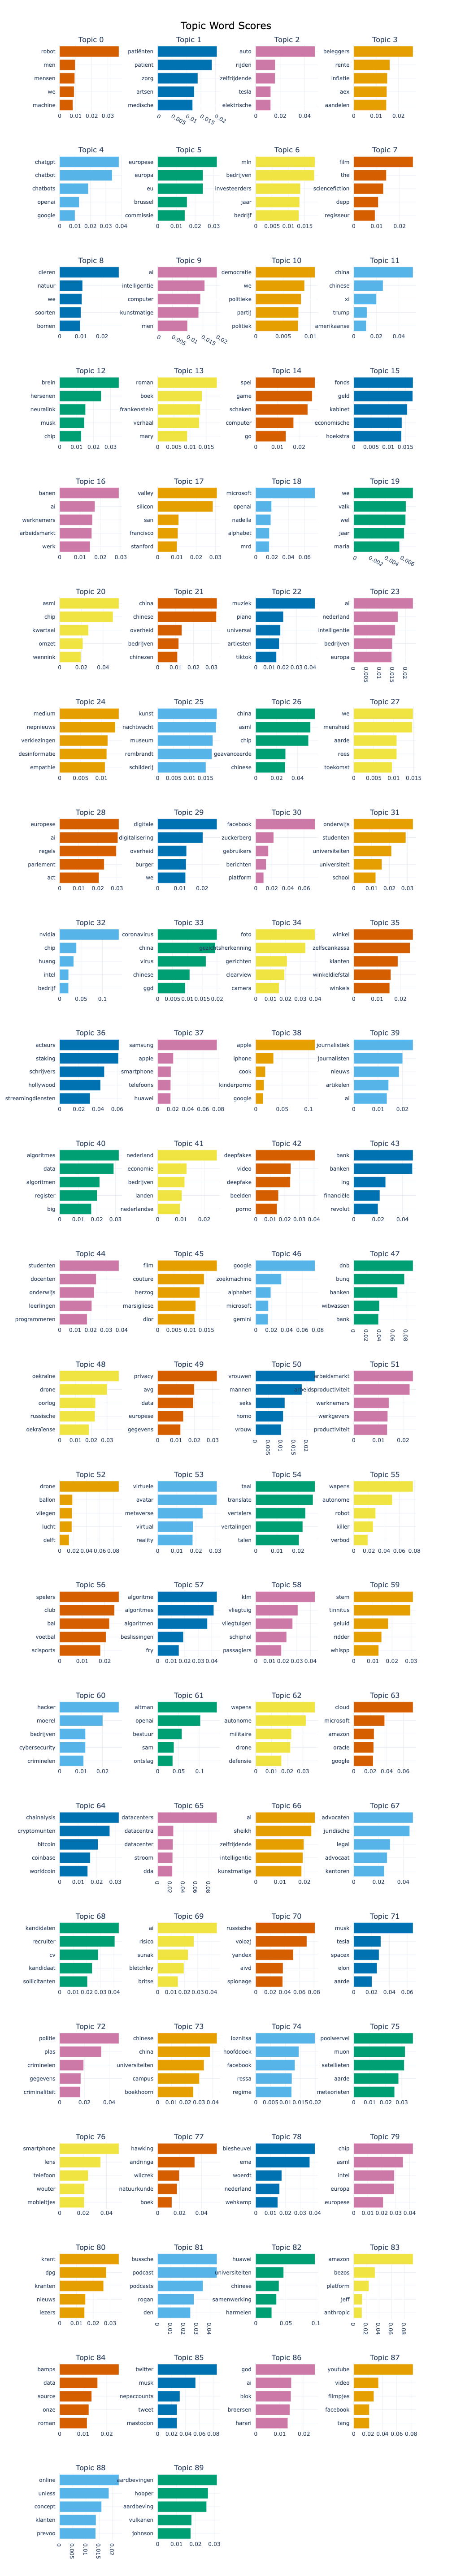

In [16]:
model.visualize_barchart(top_n_topics=90)

In [21]:
topic_details_df

Topic  Count                                       Name   
0      -1   2498                         we_jaar_mensen_wel  \
1       0    432                        robot_men_mensen_we   
2       1    147              patiënten_patiënt_zorg_artsen   
3       2    136             auto_rijden_zelfrijdende_tesla   
4       3    123               beleggers_rente_inflatie_aex   
..    ...    ...                                        ...   
87     86     12                       god_ai_blok_broersen   
88     87     12            youtube_video_filmpjes_facebook   
89     88     11              online_unless_concept_klanten   
90     89     10    aardbevingen_hooper_aardbeving_vulkanen   
91     90     10  universiteiten_spionage_chinese_hikvision   

                                       Representation   
0   [we, jaar, mensen, wel, intelligentie, zegt, k...  \
1   [robot, men, mensen, we, machine, intelligenti...   
2   [patiënten, patiënt, zorg, artsen, medische, p...   
3   [auto, rijden, zelfrijdende, tesla, elektrisch...   
4   [beleggers, rente, inflatie, aex, aandelen, am...   
..                                                ...   
87  [god, ai, blok, broersen, harari, men, we, bos...   
88  [youtube, video, filmpjes, facebook, tang, hov...   
89  [online, unless, concept, klanten, prevoo, wap...   
90  [aardbevingen, hooper, aardbeving, vulkanen, j...   
91  [universiteiten, spionage, chinese, hikvision,...   

                                  Representative_Docs  
0   [kunstmatige intelligentie best bedreigend kun...  
1   [tekenfilm maken gaat ai stuk sneller animatie...  
2   [kunstmatige intelligentie verslaat artsen ops...  
3   [robot betere kunstmatige intelligentie zelfri...  
4   [oorlogen trage economische groei laten belegg...  
..                                                ...  
87  [bedreigt kunstmatige intelligentie godsbeeld ...  
88  [youtube grijpt mountain view youtube afgelope...  
89  [online gaat winkelstraat nooit dicht verslave...  
90  [lezersreacties tof krant nieuws mei aandacht ...  
91  [laat nederland speelbal minister generaals pr...  

[92 rows x 5 columns]

Based on analyzing the topics and content, the following topics were manually merged: 

- -1 AI in society: -1
- 0 Health: 1, 12, 19, 33, 50, 54, 56, 59
- 1 Environment: 8, 58, 75, 78, 89
- 2 Art: 7, 13, 22, 25, 36, 45,
- 3 Media: 14, 39, 85, 88, 80 ,81, 87
- 4 Economy: 3, 6, 15, 16, 43, 47, 51, 64, 68 
- 5 Law: 24, 34, 35, 42, 52, 55, 60, 62, 67, 72
- 6 Politics: 5, 10, 11, 21, 28, 40, 41, 48, 49, 66, 69, 70, 74, 79, 23 
- 7 Education: 31, 44, 73, 76, 77, 82, 86, 90
- 8 Technology: 0, 2, 9, 27, 29, 53, 57, 65 
- 9 Business: 4, 17, 18, 20, 26, 30, 32, 37, 38, 46, 61, 63, 71, 83


In [17]:
# Merge the specified topics
topics_to_merge = [[1, 12, 19, 33, 50, 54, 56, 59],
                   [8, 58, 75, 78, 89],
                   [7, 13, 22, 25, 36, 45],
                   [14, 39, 85, 88, 80 ,81, 87],
                   [3, 6, 15, 16, 43, 47, 51, 64, 68],
                   [24, 34, 35, 42, 52, 55, 60, 62, 67, 72],
                   [5, 10, 11, 21, 28, 40, 41, 48, 49, 66, 69, 70, 74, 79, 23],
                   [31, 44, 73, 76, 77, 82, 86, 90],
                   [0, 2, 9, 27, 29, 53, 57, 65, 84],
                   [4, 17, 18, 20, 26, 30, 32, 37, 38, 46, 61, 63, 71, 83]]
model.merge_topics(content_titles, topics_to_merge)

In [34]:
# Get the topics and their representations
topics_info = model.get_topic_info()

# Save the topics information DataFrame to an Excel file
topics_info.to_excel('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Merged_Topic_Info.xlsx', index=False)

# Save the topics information DataFrame to a CSV file
topics_info.to_csv('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Merged_Topic_Info.csv', index=False)

Topics arranged:
- -1 AI in society: -1
- 0 Technology: 2, 9, 27, 29, 53, 57, 65
- 1 Politics: 5, 10, 11, 21, 28, 40, 41, 48, 49, 66, 69, 70, 74, 79, 23 
- 2 Business: 4, 17, 18, 20, 26, 30, 32, 37, 38, 46, 61, 63, 71, 83
- 3 Economy: 3, 6, 15, 16, 43, 47, 51, 64, 68 
- 4 Health: 1, 12, 19, 33, 50, 54, 56, 59 
- 5 Art: 13, 22, 25, 36, 45, 81, 87
- 6 Law: 24, 34, 35, 42, 52, 55, 60, 62, 67, 72
- 7 Media: 14, 39, 85, 88, 80, ,81, 87
- 8 Education: 31, 44, 73, 76, 77, 82, 86, 90
- 9 Environment: 8, 58, 75, 78, 89

In [23]:
model.get_topics()

{-1: [('we', 0.022246328484310914),
  ('jaar', 0.014825560535742755),
  ('mensen', 0.014233405312292684),
  ('wel', 0.013011375234743543),
  ('intelligentie', 0.01268669676667743),
  ('kunstmatige', 0.012182137624903732),
  ('zegt', 0.012007260891035156),
  ('nieuwe', 0.011391891814129043),
  ('gaat', 0.010897747908243225),
  ('moeten', 0.01054144716387557)],
 0: [('robot', 0.040747440280944944),
  ('we', 0.027470876669336355),
  ('mensen', 0.019451643909996912),
  ('auto', 0.019356006306047474),
  ('intelligentie', 0.018192291740770892),
  ('kunstmatige', 0.016748266185515403),
  ('men', 0.014375584320160421),
  ('wel', 0.013622172170076222),
  ('jaar', 0.01286155054987591),
  ('nieuwe', 0.012393326194674798)],
 1: [('china', 0.028164840461059135),
  ('europese', 0.022046840430905077),
  ('we', 0.019394168050648072),
  ('europa', 0.017627095347032613),
  ('chinese', 0.014903966734085599),
  ('moeten', 0.014246470556257248),
  ('nederland', 0.014052009316309339),
  ('bedrijven', 0.0140

In [24]:
#Associates the assigned topics and their probabilities with each news article in the DataFrame
data['Topic'] = topics
data['Probabilities'] = probabilities

In [25]:
topics = data['Topic'].unique()
print(topics)

[ 9 69 -1 86  8 28  0 24  1 25  4 61  2 21 46 74 22 75 35 53 12 13 29 39
 89 56 54 44 36 32 50 42 45 11 10  7 59 18 23  5 57 31 66 68 20 62 64 16
 84 15 37  3 88 51 85 67 90 33 30 48 65 27 72 40 41 55  6 60 26 70 14 38
 19 49 34 58 76 71 83 80 81 47 77 52 79 17 63 73 43 78 87 82]


- -1 AI in society: -1
- 0 Technology: 0, 2, 9, 27, 29, 53, 57, 65, 84
- 1 Politics: 5, 10, 11, 21, 28, 40, 41, 48, 49, 66, 69, 70, 74, 79, 23 
- 2 Business: 4, 17, 18, 20, 26, 30, 32, 37, 38, 46, 61, 63, 71, 83
- 3 Economy: 3, 6, 15, 16, 43, 47, 51, 64, 68 
- 4 Health: 1, 12, 19, 33, 50, 54, 56, 59 
- 5 Art: 13, 22, 25, 36, 45, 81, 87
- 6 Law: 24, 34, 35, 42, 52, 55, 60, 62, 67, 72
- 7 Media: 14, 39, 85, 88, 80, 81, 87
- 8 Education: 31, 44, 73, 76, 77, 82, 86, 90
- 9 Environment: 8, 58, 75, 78, 89

-1 = AI in society: -1
0 = 1: 0, 2: 0, 9: 0, 27: 0, 29: 0, 53: 0, 57: 0, 65: 0, 84: 0,
1 = 5: 1, 10: 1, 11: 1, 21: 1, 28: 1, 40: 1, 41: 1, 48: 1, 49: 1, 66: 1, 69: 1, 70: 1, 74: 1, 79: 1, 23: 1 
2 = 4: 2, 17: 2, 18: 2, 20: 2, 26: 2, 30: 2, 32: 2, 37: 2, 38: 2, 46: 2, 61: 2, 63: 2, 71: 2, 83:2
3 = 3: 3, 6: 3, 15: 3, 16: 3, 43: 3, 47: 3, 51: 3, 64: 3, 68: 3 
4 = 1: 4, 12: 4, 19: 4, 33: 4, 50: 4, 54: 4, 56: 4, 59: 4 
5 = 13: 5, 22: 5, 25: 5, 36: 5, 45: 5, 81: 5, 87: 5
6 = 24: 6, 34: 6, 35: 6, 42: 6, 52: 6, 55: 6, 60: 6, 62: 6, 67: 6, 72: 6
7 = 14: 7, 39: 7, 85: 7, 88: 7, 80: 7, 81: 7, 87: 7
8 = 31: 8, 44: 8, 73: 8, 76: 8, 77: 8, 82: 8, 86: 8, 90: 8
9 = 8: 9, 58: 9, 75: 9, 78: 9, 89: 9

In [26]:
data_updated = data.copy()
data_updated['Topic'] = data_updated['Topic'].replace({
    1: 0, 2: 0, 9: 0, 27: 0, 29: 0, 53: 0, 57: 0, 65: 0, 84: 0,
    5: 1, 10: 1, 11: 1, 21: 1, 28: 1, 40: 1, 41: 1, 48: 1, 49: 1, 66: 1, 69: 1, 70: 1, 74: 1, 79: 1, 23: 1, 
    4: 2, 17: 2, 18: 2, 20: 2, 26: 2, 30: 2, 32: 2, 37: 2, 38: 2, 46: 2, 61: 2, 63: 2, 71: 2, 83:2,
    3: 3, 6: 3, 15: 3, 16: 3, 43: 3, 47: 3, 51: 3, 64: 3, 68: 3, 
    1: 4, 12: 4, 19: 4, 33: 4, 50: 4, 54: 4, 56: 4, 59: 4,
    13: 5, 22: 5, 25: 5, 36: 5, 45: 5, 81: 5, 87: 5,
    24: 6, 34: 6, 35: 6, 42: 6, 52: 6, 55: 6, 60: 6, 62: 6, 67: 6, 72: 6,
    14: 7, 39: 7, 85: 7, 88: 7, 80: 7, 81: 7, 87: 7,
    31: 8, 44: 8, 73: 8, 76: 8, 77: 8, 82: 8, 86: 8, 90: 8,
    8: 9, 58: 9, 75: 9, 78: 9, 89: 9
})
data_updated

Headline   
0     Nee, kunstmatige intelligentie gaat ons niet u...  \
1     Wereldleiders zoeken grip op kunstmatige intel...   
2          Kunstmatige intelligentie is best bedreigend   
3     Mensen zijn een stuk efficiënter dan kunstmati...   
4     Bedreigt kunstmatige intelligentie ons godsbeeld?   
...                                                 ...   
6441                                 De rauwe realiteit   
6442                            No Headline In Original   
6443               Groeten uit het hart van de hightech   
6444              De complete lijst Jonge Talenten 2019   
6445                            No Headline In Original   

                                            Publication   
0              Trouw, Verdieping; Blz. 4, 5, 2044 words  \
1                     Trouw, Vandaag; Blz. 6, 528 words   
2                   Trouw, Tijdgeest; Blz. 8, 576 words   
3                     Trouw, Vandaag; Blz. 3, 741 words   
4     Trouw, Religie en Filosofie; Blz. 8, 9, 1367 w...   
...                                                 ...   
6441  Het Financieele Dagblad, MORGEN; Blz. 4, 2920 ...   
6442  Het Financieele Dagblad, PAGINA 13; Blz. 13, 1...   
6443  Het Financieele Dagblad, WEEKEND; Blz. 6, 2799...   
6444  Het Financieele Dagblad, FD PERSOONLIJK; Arbei...   
6445  Het Financieele Dagblad, DE WERELD; Blz. 30, 9...   

                                                    URL   
0     https://advance.lexis.com/api/document?collect...  \
1     https://advance.lexis.com/api/document?collect...   
2     https://advance.lexis.com/api/document?collect...   
3     https://advance.lexis.com/api/document?collect...   
4     https://advance.lexis.com/api/document?collect...   
...                                                 ...   
6441  https://advance.lexis.com/api/document?collect...   
6442  https://advance.lexis.com/api/document?collect...   
6443  https://advance.lexis.com/api/document?collect...   
6444  https://advance.lexis.com/api/document?collect...   
6445  https://advance.lexis.com/api/document?collect...   

                  News Outlet                  Type of News  Word Count   
0                       Trouw                    Verdieping        2044  \
1                       Trouw                       Vandaag         528   
2                       Trouw                     Tijdgeest         576   
3                       Trouw                       Vandaag         741   
4                       Trouw          Religie en Filosofie        1367   
...                       ...                           ...         ...   
6441  Het Financieele Dagblad                        MORGEN        2920   
6442  Het Financieele Dagblad                        PAGINA         114   
6443  Het Financieele Dagblad                       WEEKEND        2799   
6444  Het Financieele Dagblad  FD PERSOONLIJK; Arbeidsmarkt        8007   
6445  Het Financieele Dagblad                     DE WERELD         969   

                                                   Body Publication Date   
0     Welkom in de AI-fabriek serie\nDat kunstmatige...       07-12-2023  \
1     Op het Britse landgoed Bletchley Park werden t...       03-11-2023   
2     Of kunstmatige intelligentie nuttig is (Tijdge...       13-05-2023   
3     De wereld raakte het afgelopen jaar in de ban ...       21-10-2023   
4     Theologisch elftal\n'In het begin was het Woor...       16-12-2022   
...                                                 ...              ...   
6441  Grootse oplossingen\nDrie stedelijke 'ontwrich...       14-10-2017   
6442  klinkt als muziek\nDe Walkman, van Sony, is vo...       29-04-2023   
6443  Het is zover voor 'onze man in San Francisco'....       20-08-2016   
6444  Rebel werkte zes jaar bij zakenbank Morgan Sta...       17-01-2019   
6445  The Conversation (Londen)Gates Notes (VS)The E...       08-12-2018   

                                               Combined  Topic  Probabilities  
0     nee kunstmatige inte

In [27]:
# Define the topic name mapping dictionary
topic_names = {
    -1: 'AI in Society',
    0: 'Technology',
    1: 'Politics',
    2: 'Business',
    3: 'Economy',
    4: 'Healthcare',
    5: 'Art',
    6: 'Law',
    7: 'Media',
    8: 'Education',
    9: 'Environment'
}

# Create a new column 'Topic Name' by mapping the 'Topic' column using the topic_names dictionary
data_updated['Topic Name'] = data_updated['Topic'].map(topic_names)

data_updated

Headline   
0     Nee, kunstmatige intelligentie gaat ons niet u...  \
1     Wereldleiders zoeken grip op kunstmatige intel...   
2          Kunstmatige intelligentie is best bedreigend   
3     Mensen zijn een stuk efficiënter dan kunstmati...   
4     Bedreigt kunstmatige intelligentie ons godsbeeld?   
...                                                 ...   
6441                                 De rauwe realiteit   
6442                            No Headline In Original   
6443               Groeten uit het hart van de hightech   
6444              De complete lijst Jonge Talenten 2019   
6445                            No Headline In Original   

                                            Publication   
0              Trouw, Verdieping; Blz. 4, 5, 2044 words  \
1                     Trouw, Vandaag; Blz. 6, 528 words   
2                   Trouw, Tijdgeest; Blz. 8, 576 words   
3                     Trouw, Vandaag; Blz. 3, 741 words   
4     Trouw, Religie en Filosofie; Blz. 8, 9, 1367 w...   
...                                                 ...   
6441  Het Financieele Dagblad, MORGEN; Blz. 4, 2920 ...   
6442  Het Financieele Dagblad, PAGINA 13; Blz. 13, 1...   
6443  Het Financieele Dagblad, WEEKEND; Blz. 6, 2799...   
6444  Het Financieele Dagblad, FD PERSOONLIJK; Arbei...   
6445  Het Financieele Dagblad, DE WERELD; Blz. 30, 9...   

                                                    URL   
0     https://advance.lexis.com/api/document?collect...  \
1     https://advance.lexis.com/api/document?collect...   
2     https://advance.lexis.com/api/document?collect...   
3     https://advance.lexis.com/api/document?collect...   
4     https://advance.lexis.com/api/document?collect...   
...                                                 ...   
6441  https://advance.lexis.com/api/document?collect...   
6442  https://advance.lexis.com/api/document?collect...   
6443  https://advance.lexis.com/api/document?collect...   
6444  https://advance.lexis.com/api/document?collect...   
6445  https://advance.lexis.com/api/document?collect...   

                  News Outlet                  Type of News  Word Count   
0                       Trouw                    Verdieping        2044  \
1                       Trouw                       Vandaag         528   
2                       Trouw                     Tijdgeest         576   
3                       Trouw                       Vandaag         741   
4                       Trouw          Religie en Filosofie        1367   
...                       ...                           ...         ...   
6441  Het Financieele Dagblad                        MORGEN        2920   
6442  Het Financieele Dagblad                        PAGINA         114   
6443  Het Financieele Dagblad                       WEEKEND        2799   
6444  Het Financieele Dagblad  FD PERSOONLIJK; Arbeidsmarkt        8007   
6445  Het Financieele Dagblad                     DE WERELD         969   

                                                   Body Publication Date   
0     Welkom in de AI-fabriek serie\nDat kunstmatige...       07-12-2023  \
1     Op het Britse landgoed Bletchley Park werden t...       03-11-2023   
2     Of kunstmatige intelligentie nuttig is (Tijdge...       13-05-2023   
3     De wereld raakte het afgelopen jaar in de ban ...       21-10-2023   
4     Theologisch elftal\n'In het begin was het Woor...       16-12-2022   
...                                                 ...              ...   
6441  Grootse oplossingen\nDrie stedelijke 'ontwrich...       14-10-2017   
6442  klinkt als muziek\nDe Walkman, van Sony, is vo...       29-04-2023   
6443  Het is zover voor 'onze man in San Francisco'....       20-08-2016   
6444  Rebel werkte zes jaar bij zakenbank Morgan Sta...       17-01-2019   
6445  The Conversation (Londen)Gates Notes (VS)The E...       08-12-2018   

                                               Combined  Topic  Probabilities   
0     nee kunstmatige int

In [28]:
# Check if all topics have been proper labeled
topics = data_updated['Topic'].unique()
print(topics)

[ 0  1 -1  8  9  6  4  5  2  7  3]


# Save the DataFrame to an Excel file
data_updated.to_excel('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Updated_Data_And_Topics.xlsx', index=False)

# Save the DataFrame to a CSV file
data_updated.to_csv('/Users/helgegeurtjacobusmoes/Desktop/thesis data/Updated_Data_And_Topics.csv', index=False)

In [30]:
# Calculate the frequency of topics
topic_frequency = data_updated['Topic'].value_counts()

for topic, frequency in topic_frequency.items():
    print("Topic: ", topic)
    print("Frequency: ", frequency)
    print()

Topic:  -1
Frequency:  2498

Topic:  0
Frequency:  821

Topic:  1
Frequency:  595

Topic:  2
Frequency:  594

Topic:  3
Frequency:  476

Topic:  4
Frequency:  406

Topic:  6
Frequency:  279

Topic:  7
Frequency:  251

Topic:  5
Frequency:  231

Topic:  8
Frequency:  151

Topic:  9
Frequency:  144



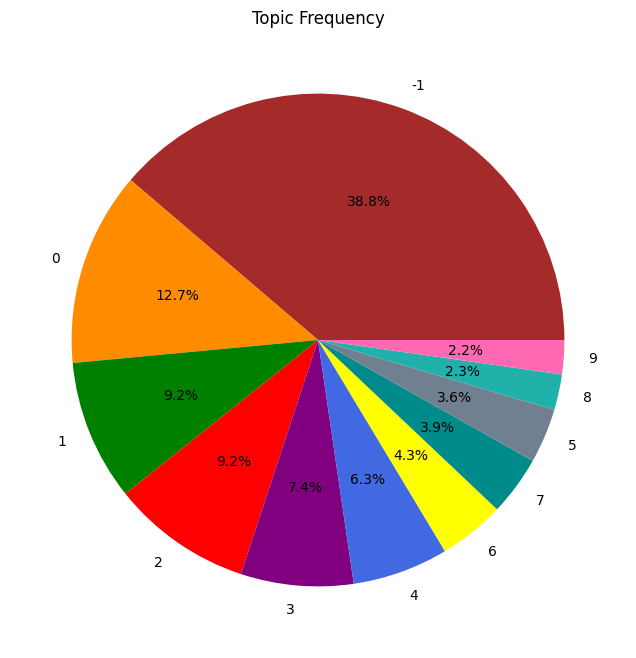

In [31]:
# Get the topic labels and frequencies
labels = topic_frequency.index
counts = topic_frequency.values

# Color palette adjusted to the specific colors used in the line graph
color_palette = ['brown', 'darkorange', 'green', 'red', 'purple', 'royalblue', 'yellow', 'darkcyan', 'slategray', 'lightseagreen', 'hotpink']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=color_palette)
plt.title('Topic Frequency')

# Display the pie chart
plt.show()

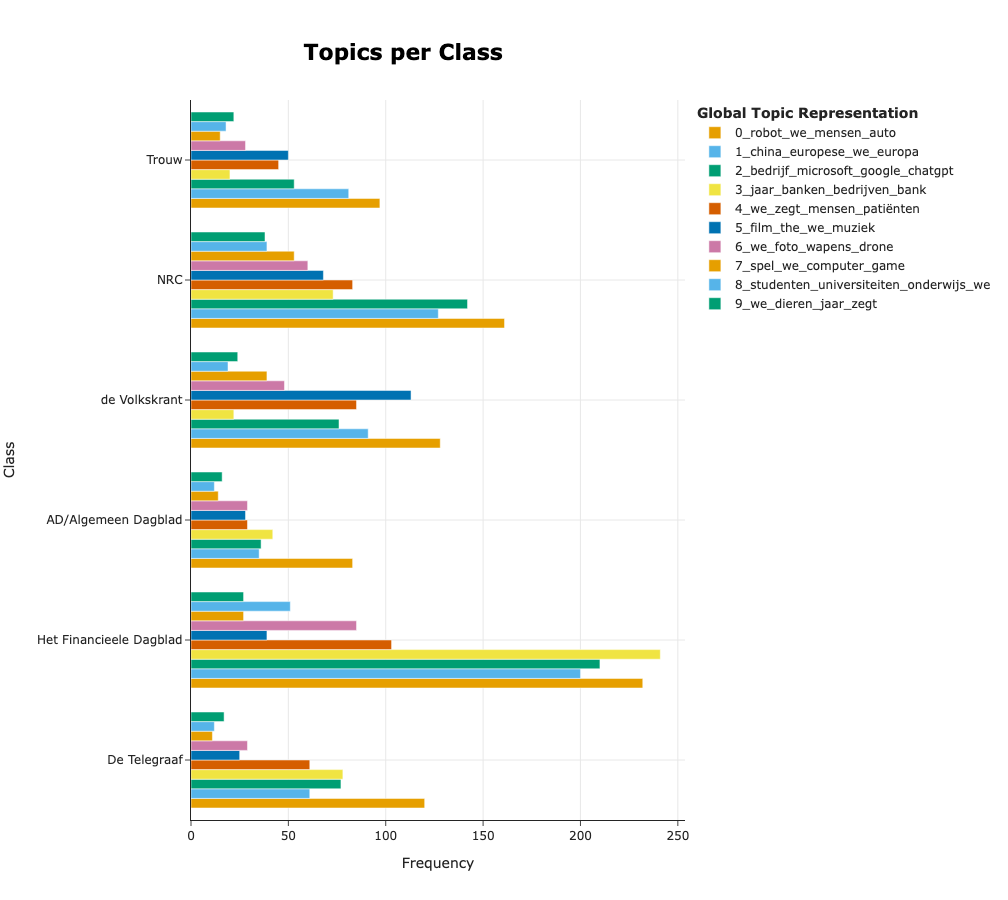

In [32]:
# Get topics per source
topics_per_source = model.topics_per_class(content_titles, classes=data_updated['News Outlet'])

# Visualize topics per source
model.visualize_topics_per_class(topics_per_source)